In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np
from math import log
import re

In [2]:
en_lines = []
jp_lines = []
with open("train.en", 'r') as file:
    en_lines = file.readlines()
with open("train.jp", 'r') as file:
    jp_lines = file.readlines()
with open('test.jp', 'r') as file:
    jp_test = file.readlines()

SPACE_NORMALIZER = re.compile("\s+")
def word_tokenize(line):
    line = SPACE_NORMALIZER.sub(" ", line)
    line = line.strip()
    return line.split()

def tokenize(lines):
    line_tokens = []
    all_tokens = dict()
    counts = []
    for line in lines:
        tokens = word_tokenize(line)
        for t in tokens:
            if t in all_tokens:
                all_tokens[t]+=1
            else:
                all_tokens[t]=1
        line_tokens.append(tokens)
        counts.append(len(tokens))
    return line_tokens, counts, all_tokens

en_tokens,en_counts,en_all = tokenize(en_lines)
jp_tokens,jp_counts,jp_all = tokenize(jp_lines)
test_jp = tokenize(jp_test)

/Users/megadix/bin/miniconda3/envs/nlu/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


The correlation: J = 1.102E+3.431


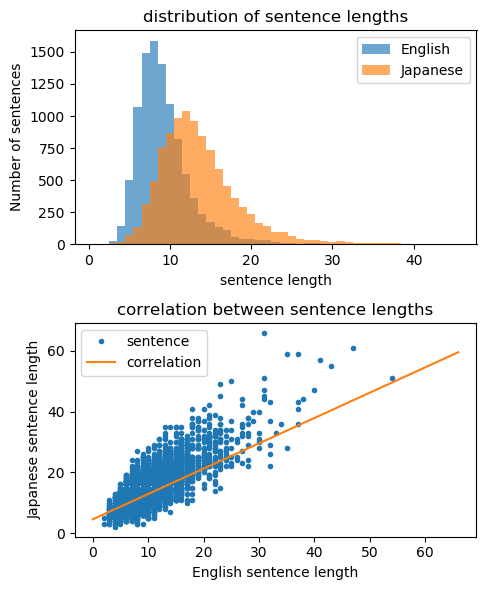

In [102]:
fig,(ax3,ax4)=plt.subplots(2,1,figsize=(5,6))
#ax1.hist(en_counts,np.arange(0.5, max(en_counts) + 0.5, 1))
#ax2.hist(jp_counts,np.arange(0.5, max(jp_counts) + 0.5, 1))
max_length = max([max(en_counts),max(jp_counts)])
ax3.hist(en_counts,np.arange(0.5, int(max_length*0.7) + 0.5, 1), label="English", alpha=0.65)
ax3.hist(jp_counts,np.arange(0.5, int(max_length*0.7) + 0.5, 1), label="Japanese", alpha=0.65)

w,_,_,_ = np.linalg.lstsq(np.vstack([np.ones(len(en_counts)), en_counts]).T,jp_counts)
reg_y = w.dot(np.array([[1,0],[1,max(en_counts)]]))
ax4.plot(en_counts, jp_counts, '.', label="sentence")
ax4.plot([0,max_length],reg_y,label="correlation")

#ax1.set_title("distribution of English sentence lengths")
#ax2.set_title("distribution of Japanese sentence lengths")
ax3.set_title("distribution of sentence lengths")
ax3.set_xlabel("sentence length")
ax3.set_ylabel("Number of sentences")
ax4.set_title("correlation between sentence lengths")
ax4.set_xlabel("English sentence length")
ax4.set_ylabel("Japanese sentence length")

ax3.legend()
ax4.legend()
plt.tight_layout()
plt.savefig("q2.pdf")
plt.savefig("q2.jpg")

print("The correlation: J = {0:.3f}E+{1:.3f}".format(w[1],w[0]))

It can be infered that the Japanese sentences are generally longer (in number of tokens) than the corresponding English sentences. This means in the alignment of English-Japanese pairs, each English token aligns with more than one Japanese token on average.

In [4]:
print(np.mean(en_counts), np.median(en_counts), np.std(en_counts))
print(np.mean(jp_counts), np.median(jp_counts), np.std(jp_counts))

9.3086 9.0 3.596938425939482
13.6899 13.0 5.161040398020539


In [5]:
print("There are {} tokens in the English data".format(sum(en_counts)))
print("There are {} tokens in the Japanese data".format(sum(jp_counts)))

There are 93086 tokens in the English data
There are 136899 tokens in the Japanese data


In [6]:
print("There are {} types in the English data".format(len(en_all)))
print("There are {} types in the Japanese data".format(len(jp_all)))

There are 7040 types in the English data
There are 8058 types in the Japanese data


In [7]:
def replace_count(tokens, all_tokens):
    count = 0
    for lines in tokens:
        for t in lines:
            if all_tokens[t]==1:
                count+=1
    return count
en_rep = replace_count(en_tokens, en_all)
jp_rep = replace_count(jp_tokens, jp_all)


print("{} tokens in the English data will be replaced by <UNK>".format(en_rep))
print("{} tokens in the Japanese data will be replaced by <UNK>".format(jp_rep))

3331 tokens in the English data will be replaced by <UNK>
4113 tokens in the Japanese data will be replaced by <UNK>


In [8]:
print("English TTR before replacement: {}".format(len(en_all)/sum(en_counts)))
print("Japanese TTR before replacement: {}".format(len(jp_all)/sum(jp_counts)))
print("English TTR after replacement: {}".format((len(en_all)-en_rep+1)/sum(en_counts)))
print("Japanese TTR after replacement: {}".format((len(jp_all)-jp_rep+1)/sum(jp_counts)))

English TTR before replacement: 0.07562898824742711
Japanese TTR before replacement: 0.058860912059255366
English TTR after replacement: 0.03985561738607309
Japanese TTR after replacement: 0.028824169643313684


Fixed sized representation degrades as sentence length increases. As Japanese sentences are generally longer, the information bottleneck of the encoder may have more impact on translating from Japanese to English than on the reverse. Using attentional NMT can ease this problem. The type-token ratio (TTR) (0.076 for English and 0.059 for Japanese) measures the lexical variability of the data. A slightly high TTR of English data makes it harder to train than Japanese. Low frequency types carry high information. More types getting replaced in Japanese data means more information loss, thus it might result in lower quality when translating from English to Japanese.

In [9]:
def find_words(*args):
    c = 0
    for i, line in enumerate(en_lines):
        match = True
        for w in args:
            if w not in line and w not in jp_lines[i]:
                match = False
        if match:
            c+=1
            #print(c, jp_lines[i], line)
    return c

en_occur = dict()
jp_occur = dict()
for line in en_tokens:
    words = set(line)
    for w in words:
        if w not in en_occur:
            en_occur[w]=1
        else:
            en_occur[w]+=1
            
for line in jp_tokens:
    words = set(line)
    for w in words:
        if w not in jp_occur:
            jp_occur[w]=1
        else:
            jp_occur[w]+=1

def PMI(w1,w2):
    epsilon = 1e-6
    return log((find_words(w1,w2)+epsilon)*len(en_lines)/find_words(w1)/find_words(w2),2)


#find_words('bliss') # 2
#find_words('幸福','bliss') # 1
#find_words('ignorance') # 2
#find_words('ignorance', '幸福') #0
#find_words('is') # 3381
#find_words('is', '幸福') # 6
#find_words('幸福','happy') # 5
#find_words('幸福','sorry') # 0
#find_words('tonight', '今日') #0
#find_words('i &apos;m','happy') # 0
#find_words('i &apos;m','sorry') # 12

#PMI('貴方','i') # 0.167
#PMI('貴方','you') # 2.567

#PMI('幸福','bliss') # 8.48
#PMI('は','is') # 0.154
#PMI('幸福','happy') # 6.673
#PMI('tonight','今日') # -17.340
#PMI('winter','冬') # 9.828

#PMI('結婚','marry') # 7.830331545561133
#st_PMI('marry','結婚')
#st_PMI('marrying','結婚')

In [10]:
trans = []
with open("../model_translations.txt",'r') as lex, open("../base_translations.txt",'r') as base,\
open("test.en",'r') as tgt, open("test.jp","r") as src:
    for s,t,l,b in zip(src,tgt,lex,base):
        trans.append({'src':word_tokenize(s),'tgt':word_tokenize(t),'lex':word_tokenize(l),'bas':word_tokenize(b)})
    
src_words = list(test_jp[2].keys())

def num_match(s1,s2):
    count = 0
    for w in s1:
        if w in s2:
            count+=1
    return count

freq_all = []
lex_all = []
bas_all = []
for src_w in src_words:
    freq = jp_all[src_w] if src_w in jp_all else 0
    
    s_count = 0
    lex_match = 0
    bas_match = 0
    
    for s in trans:
        if src_w in s['src']:
            s_count+=1
            lex_match += num_match(s['tgt'],s['lex'])
            bas_match += num_match(s['tgt'],s['bas'])
    if freq>0 and freq<5000:
        freq_all.append(freq)
        lex_all.append(lex_match/s_count)
        bas_all.append(bas_match/s_count)

pearson base: 0.006143822163844437, lex: 0.012689310496811318
spearman base: 0.1110806907848583, lex: 0.12812556394750896


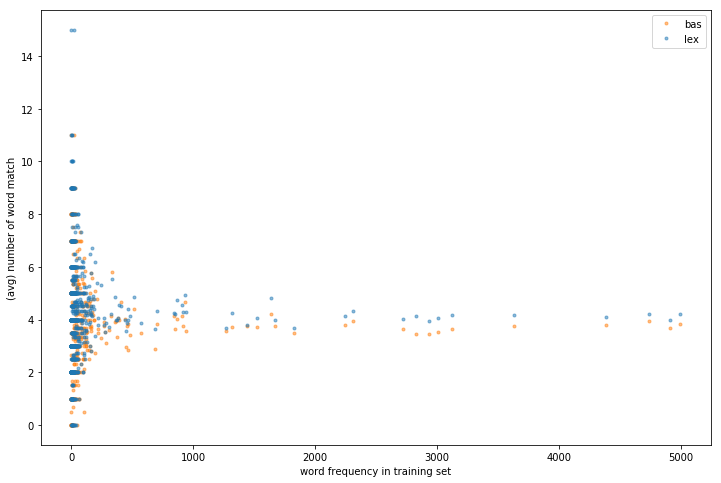

In [11]:
from scipy.stats import spearmanr, pearsonr
        
fig, (ax1) = plt.subplots(1,1,figsize=(12,8))
ax1.plot(freq_all,bas_all, '.', label='bas', color='C1' ,alpha=0.5)
ax1.plot(freq_all,lex_all, '.', label="lex", color='C0', alpha=0.5)

ax1.legend()
ax1.set_xlabel("word frequency in training set")
ax1.set_ylabel("(avg) number of word match")
print("pearson base: {}, lex: {}".format(pearsonr(freq_all,bas_all)[0],pearsonr(freq_all,lex_all)[0]))
print("spearman base: {}, lex: {}".format(spearmanr(freq_all,bas_all)[0],spearmanr(freq_all,lex_all)[0]))

/Users/megadix/bin/miniconda3/envs/nlu/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


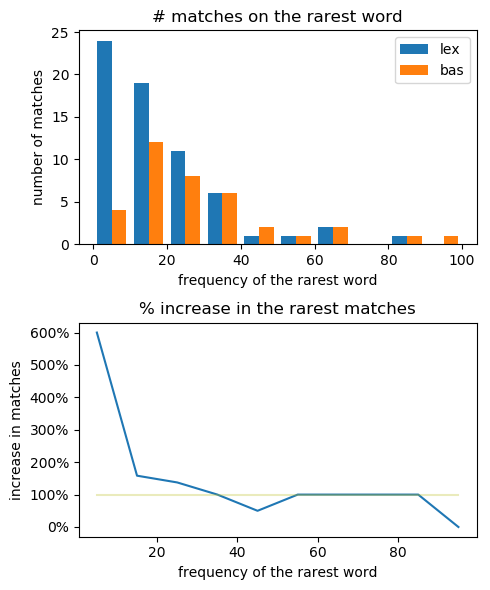

In [103]:
min_freqs = []
lex_match = []
base_match = []
for s in trans:
    min_freq = 100000
    min_word = None
    for src_w in s['tgt']:
        f = en_all[src_w] if src_w in en_all else 0
        if f<min_freq:
            min_freq = f
            min_word = src_w
    
    min_freqs.append(min_freq)
    if min_word in s['lex']:
        lex_match.append(min_freq)
    if min_word in s['bas']:
        base_match.append(min_freq)

t = 10
bins = np.arange(0,t*10+t,t)


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,6))
(lex,bas),_,_=ax1.hist([lex_match,base_match], bins, label=['lex','bas'])
ax1.legend()
ax1.set_xlabel("frequency of the rarest word")
ax1.set_ylabel("number of matches")
ax1.set_title("# matches on the rarest word")

perc = np.array(lex)/np.array(bas)
perc[np.isnan(perc)]=1

ax2.plot(bins[:-1]+t/2, perc*100)
ax2.plot(bins[:-1]+t/2,np.ones(len(bins[:-1]))*100, color="C8", alpha=0.3)
yticks = ticker.PercentFormatter()
ax2.yaxis.set_major_formatter(yticks)
ax2.set_xlabel("frequency of the rarest word")
ax2.set_ylabel("increase in matches")
ax2.set_title("% increase in the rarest matches")

plt.tight_layout()
fig.savefig("q8_2.pdf")

1323

In [28]:
def match_freq(s1,s2):
    freq = []
    for w in s1:
        if w in s2:
            freq.append(en_all[w])
    return freq

lex_match_list = []
bas_match_list = []
for s in trans:
    lex_match_list += match_freq(s['tgt'],s['lex'])
    bas_match_list += match_freq(s['tgt'],s['bas'])

    

/Users/megadix/bin/miniconda3/envs/nlu/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


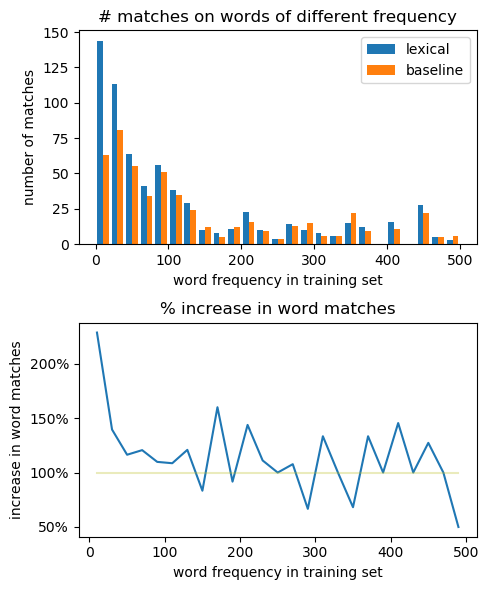

In [101]:
plt.style.use('default')
t = 20
fbins = np.arange(0,500+t,t)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(5,6))
(num_lex,num_bas),_,_ = ax1.hist([lex_match_list,bas_match_list], fbins, label=['lexical','baseline'])

ax1.legend()
ax1.set_title("# matches on words of different frequency")
ax1.set_ylabel("number of matches")
ax1.set_xlabel("word frequency in training set")
perc = num_lex/num_bas
perc[np.isnan(perc)]=1

ax2.plot(fbins[:-1]+t/2,perc*100, '-')
ax2.plot(fbins[:-1]+t/2,np.ones(len(fbins[:-1]))*100, color="C8", alpha=0.3)
ax2.set_title("% increase in word matches")
ax2.set_ylabel("increase in word matches")
ax2.set_xlabel("word frequency in training set")


yticks = ticker.PercentFormatter()
ax2.yaxis.set_major_formatter(yticks)


plt.tight_layout()
fig.savefig("q8.pdf")



25